## Re-create the IPCC_AR5 Figure12.5 from the CMIP5 ts data  
[IPCC-AR5 Figure 12.5](http://www.climatechange2013.org/images/figures/WGI_AR5_Fig12-5.jpg)

### Method: load the monthly CMIP5 ts (surface temperature) files, do some data cleaning and plot the figure

* this notebook is what I use for general multi-model statistics - not just global means. So the models are regridded to
a common 2x2 degree grid and the global mean is only computed when making the figure
* the Raw CMIP5 netcdf files were concatenated on our home machine using xarray.mfdataset for each model and scenerio (historical/rcp45/rcp85)
* saved in zarr format, using to_zarr
* uploaded to the Google Cloud Storage

In [1]:
import xarray as xr
import numpy as np
%matplotlib inline
from glob import glob
from os import system
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
from pathlib import Path
#import xesmf as xe
xr.set_options(enable_cftimeindex=True)

cloud = False

### In this next cell are the basic functions (all in one cell so you can collapse it on first read)

In [2]:
if cloud:
    def listd(fs,path):
        return fs.ls(path)
    def openzarr(path):
        return xr.open_zarr(gcsfs.GCSMap(path))
else:
    def listd(fs,path):
        return glob(path+'/*/')
    def openzarr(path):
        return xr.open_zarr(path)

def find_models(data_fs,base_path,var,scenario):
    """
    Search for all files in path matching the variable and scenario
    returns:
         models: list of model names for given scenario
    """
    allmodels = listd(data_fs,base_path)
    fmodels = []
    for model in allmodels:
        run = listd(data_fs,model)
        for sce in run:
            if scenario in sce:
                model = sce.split("/")[-3]
                fmodels += [model]
                
    umodels = sorted(fmodels)

    paths = []
    for model in umodels:
        path = base_path + model + '/' + scenario
        paths += [path]
        
    return umodels, paths

def get_datasets(var, umodels, paths, toprint=True):
    """  
    Load all datasets
    returns:  
        ds : list of all models for given scenario
    """  
    ds = []
    for idx, model in enumerate(umodels):
        path = paths[idx]
        dss = openzarr(path)
        start_date = dss.attrs['start_date']
        nt = dss.time.shape[0]
        dss['time'] = to_enso(start_date,nt)
        
        ds += [dss[var]]
        
        if toprint:
            fstr = '{:2g}: {:18} , {:12} , nt={:5g},{:5.0f}Mb'
            print(fstr.format(idx,model,start_date,nt,dss.nbytes/ 1e6))
    return ds

def find_short(ds, century, umodels, toprint=True):
    """
    Identify models which are useful, finding those which do not span the interval
    returns:  
        bad_models: list of the bad models
    """  

    slist = century.split('-')
    [start_year, stop_year] = list(map(int, slist))
    
    bad_models =[]
    for idx, dss in enumerate(ds):
        model = umodels[idx]
        
        tfirst = enso2date(dss.time[0].values)
        tlast = enso2date(dss.time[-1].values)
        
        if (int(str(tfirst)[0:4]) > start_year):
            print('trouble with model',model,'since start date is past',start_year)
            bad_models += [model]

        if (int(str(tlast)[0:4]) < stop_year):
            print('trouble with model',model,'since stop date is before',stop_year)
            bad_models += [model]
            
        if toprint:
            fstr = '{:2g}: {:18} , {:12} to {:12}'
            print(fstr.format(idx,model,tfirst,tlast,))
    return bad_models

def regrid_all(ds,umodels):
    """
    Define common grid and use xESMF to regrid all datasets 
    returns:
        data_2x2: a list of datasets on the common grid
    """      
    # regrid all lon,lat data to a common 2x2 grid
    import xesmf as xe
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89,89, 2)),
                         'lon': (['lon'], np.arange(-179,179,2)),
                        })
    data_2x2 =[]
    for model,dss in zip(umodels,ds):
        #print(model,'nt=',dss.time.shape[0])
        regridder = xe.Regridder(dss, ds_out, 'bilinear', periodic=True, reuse_weights=True )
        data_2x2 += [regridder(dss)]
    return data_2x2

def concat_all(ds_2x2,umodels):
    """
    Concatenates all of the good models into one DataArray
    """  
    dsall = xr.concat(ds_2x2,dim='model') #,coords=['time','lat','lon'])
    dsall['names'] = ('model',umodels)
    return dsall

def compute_global_mean(ds):
    """
    Weights each grid point by the cos(latitude), computes global mean, normalizing by global mean of the weights
    returns:
        list of DataArrays:  global mean model by model
    """  
    coslat = np.cos(np.deg2rad(ds.lat))
    d_ones = xr.ones_like(ds)
    weight_mean = (d_ones*coslat).mean(['lat','lon'])
    ds_globalmean = ((ds * coslat).mean(['lat','lon'])/weight_mean).compute()
    return ds_globalmean

# N.B. Once cftime is working properly the following functions could be replaced
#   (we need to be able to use resample ...)
def monthly2yearly(century,ds):
    """
    converts a DataArray on a monthly grid to one on a yearly grid, replacing the time grid
    returns:
        list of DataArrays:  yearly mean model by model
    """  
    slist = century.split('-')
    [start_year, stop_year] = list(map(int, slist))
    start = to_enso(str(start_year)+'-01-16')[0]
    stop  = to_enso(str(stop_year)+'-12-16')[0]

    ds_yearly=[]
    for idx, dss in enumerate(ds):
        print('year:',idx)
        dss = dss.sel(time=slice(start, stop))
        num_of_bins = dss.time.shape[0]/12
        dnew = dss.groupby_bins('time', num_of_bins).mean('time').compute()
        dyearly = dnew.rename({'time_bins':'time'}) 
        dyearly['time'] = start_year + np.arange(dyearly.time.shape[0])
        ds_yearly += [dyearly]
    return ds_yearly

def to_enso(start_time,nt=1):
    """
    Parse the time grid of a Dataset and replace by an enso time grid (months since 1960).
    """
    import numpy as np
    # get the reference year from start_time
    ryear,rmonth,rday = start_time[0:10].split('-')
    return (int(ryear)-1960)*12 + int(rmonth) - 0.5 + np.arange(0,nt)

def enso2date(T0,ryear=1960,leap=True):
    """
    Print the date corresponding to an enso-time (months since 1960). The reference year can be changed.
    """
    norm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    iy = ryear + int(T0/12)
    if T0 < 0:
        iy = iy - 1
    res = T0 - (iy - ryear)*12
    im = int(res) + 1
    if im == 13:
        im = 1
        iy = iy + 1
    if leap & (im == 2) &  (iy % 4 == 0 ):   
        id = 1 + int(29 * (res - int(res)))
    else:
        id = 1 + int(norm[im-1] * (res - int(res)))
    return str(iy)+'/'+str(im)+'/'+str(id)    

## Connect to Dask Distributed Cluster when done debugging

In [3]:
#from dask.distributed import Client, progress

#from dask_kubernetes import KubeCluster
#cluster = KubeCluster(n_workers=10)
#cluster

In [4]:
#client = Client(cluster)
#client

## Lets get started. We need to specify where our data lives in the google file system

In [5]:
if cloud:
    import gcsfs
    base_path = 'pangeo-data/CMIP5-ts/'
    data_fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')
else: 
    base_path = '/d1/nhn2/zarr/CMIP5-ts/'
    data_fs = ''

## For each scenario and time interval:
* make a list of available models
* load the datasets for all models
* eliminate the models which do not have the full time interval
* calculate the annual means
* regrid to a global 2x2 degree grid (until we have xesmf, just calculate the global mean)
* concatenate the models

In [6]:
%%time
var = 'ts'
recompute_all = True
plot_global = True
plot_nino34 = False
save_netcdf = True

if recompute_all:
    
    # Each of the following scenarios and time periods has a different subset of CMIP5 models available
    # These subsets are different for each variable chosen
    # YOU CAN PICK AND CHOOSE WHICH TO CALCULATE 
    all = []
    all += [['historical','1861-2005']]
    all += [['historical','1850-1860']]
    all += [['rcp45','2100-2300']]
    all += [['rcp45','2006-2099']]
    all += [['rcp85','2006-2099']]
    all += [['rcp85','2100-2300']]
    
    ds_master = []   # list of datasets for each scenario,century
    scenario_last = ''
    for scenario,century in all:
        print('SCENARIO=',scenario,'TIME RANGE',century)
        if scenario in scenario_last:
            print('\n same scenario, re-use ds \n')
            ds = ds2; models = models2
        else:
            models, paths = find_models(data_fs,base_path,var,scenario)
            print('total number of models available:',len(models),'\n',models)
            ds = get_datasets(var, models, paths, toprint=False)
            ds2 = ds.copy(); models2 = models.copy()
        scenario_last = scenario
        
        bad_models =  find_short(ds, century, models, toprint=False)

        bad_models = sorted(list(set(bad_models)))  
        for model in bad_models:
            idx = models.index(model)
            del models[idx],ds[idx]

        print('\n number of good models with data in the specified time range:',len(models),'\n',models)
        
        print('\n calculating annual means')
        ds_yearly = monthly2yearly(century,ds)

        print('\n regridding to 2x2 grid')
        ds_temp = regrid_all(ds_yearly,models)
        
        print('\n concatenating time series')
        dsall = concat_all(ds_temp,models)

        sctype = scenario+':'+century

        if save_netcdf:
            dsall.to_netcdf('ts-'+sctype+'.nc',encoding={'time':{'dtype':'float32'},'lon':{'dtype':'float32'},'lat':{'dtype':'float32'}})
        
        dsall.attrs = [('sctype',sctype)]       
        ds_master += [dsall.to_dataset(name=var)]        

SCENARIO= historical TIME RANGE 1861-2005
total number of models available: 49 
 ['ACCESS1-0', 'ACCESS1-3', 'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CESM1-CAM5-1-FV2', 'CESM1-FASTCHEM', 'CESM1-WACCM', 'CMCC-CESM', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5-2', 'CSIRO-Mk3-6-0', 'CSIRO-Mk3L-1-2', 'CanCM4', 'CanESM2', 'FGOALS-g2', 'FGOALS-s2', 'FIO-ESM', 'GFDL-CM2p1', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'HadCM3', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC4h', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MPI-ESM-P', 'MRI-CGCM3', 'MRI-ESM1', 'NorESM1-M', 'NorESM1-ME', 'bcc-csm1-1', 'bcc-csm1-1-m', 'inmcm4']
trouble with model CanCM4 since start date is past 1861
trouble with model MIROC4h since start date is past 1861

 number of good models with data in the specified time range: 47 
 ['ACCESS1-0', 'ACCESS1-3', 'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5

## Plot figure

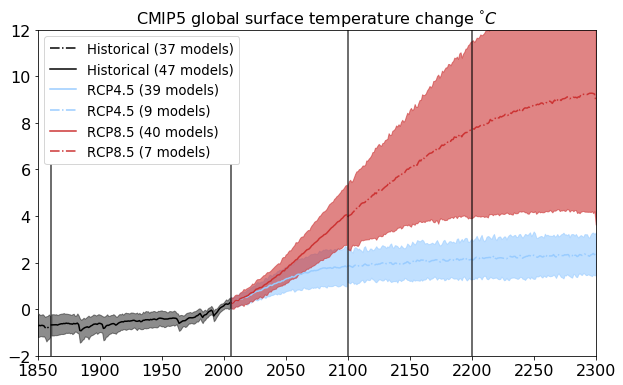

In [8]:
if plot_global:
    l = ['historical:1850-1860','historical:1861-2005','rcp45:2006-2099','rcp45:2100-2300','rcp85:2006-2099','rcp85:2100-2300']
    sctypelist = l; markerlist = l.copy(); colorlist = l.copy(); tnamelist = l.copy(); alphalist = l.copy()
    for idx,sctype in enumerate(sctypelist):
        markerlist[idx] = '-'; alphalist[idx] = 0.6
        if 'hist' in sctype:
            colorlist[idx] = 'black'; alphalist[idx] = 0.45; tnamelist[idx] = 'Historical'
            if '1850-1860' in sctype:
                markerlist[idx] = '-.'
        if 'rcp45' in sctype:
            colorlist[idx] = '#99CCFF'; tnamelist[idx] = 'RCP4.5'  
        if 'rcp85' in sctype:
            colorlist[idx] = '#CC3333';  tnamelist[idx] = 'RCP8.5'  
        if '2100-2300' in sctype:
                markerlist[idx] = '-.'
    
    # find the climatology dataset:    
    for ds in ds_master:
        if 'historical:1861-2005' in ds[var].attrs['sctype']:
            hvar = compute_global_mean(ds).compute()
  
    hmodels = hvar.names.values.tolist()

    # for each model, compute the time mean from the climatology interval: 1986-2005
    tgm = hvar.sel(time=slice(1986,2005)).mean('time').load()
   
    # calculate the model mean tgm, for use in models which do not have a climatological reference run
    tgm0 = tgm[var].mean('model')

    plt.figure(figsize=(10,6))
    rcParams.update({'font.size': 16})
        
    for idx,sctype in enumerate(sctypelist):
        tname = tnamelist[idx];marker=markerlist[idx];color=colorlist[idx];alpha=alphalist[idx]
        data_exists = False
        for ds in ds_master:
            if sctype in ds[var].attrs['sctype']:
                tvar = compute_global_mean(ds).load()
                data_exists = True
        if data_exists:
            year = tvar.time.values

            #find the climatology for each models in this scenario:century
            tclimo = 0*tvar[var].mean('time')
            for idx,model in enumerate(tvar.names.values):
                if model in hmodels:
                    hidx = hmodels.index(model)
                    tclimo[idx] = tgm[var][hidx]
                else:
                    #print('using model mean climo data:',model)
                    tclimo[idx] = tgm0

            num_models = tvar[var].shape[0]
            range5 = 1.64*(tvar - tclimo)[var].std('model')  # use std = 1.64 to give 95% and 5% of values
            tvar_mean = (tvar - tclimo)[var].mean('model')
            tvar_95 = tvar_mean + range5
            tvar_05 = tvar_mean - range5
            label = tname+' ('+str(num_models)+' models)'
            plt.plot(year, tvar_mean, marker, color=color, label=label)
            plt.fill_between(year, tvar_05, tvar_95, color=color, alpha=alpha)

    plt.plot((1861, 1861), (-2, 6.2), 'k-', linewidth=1.5, alpha=0.75)
    plt.plot((2006, 2006), (-2, 6.2), 'k-', linewidth=1.5, alpha=0.75)
    plt.plot((2100, 2100), (-2, 12), 'k-', linewidth=1.5, alpha=0.75)
    plt.plot((2200, 2200), (-2, 12), 'k-', linewidth=1.5, alpha=0.75)
    plt.ylim(-2,12) 
    plt.xlim(1850,2300) 
    vtitle = r'CMIP5 global surface air temperature change $^\degree C$'
    if var == 'ts': 
        vtitle = r'CMIP5 global surface temperature change $^\degree C$'
    plt.title(vtitle,fontsize=16)
    plt.legend(loc='upper left',fontsize='small')
    figfile = 'global_' + var + '.png'
    #plt.savefig(figfile)